In [271]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.stats
from matplotlib import pyplot as plt

In [125]:
plt.style.use('ggplot')

### A:

Simulate a single kinesin-type motor stepping along a microtubule (MT). At
t=0 (the start of a ‘run’) it should attach to a microtubule. At each subsequent
timestep it should have a probability of stepping, or falling off the MT (which ends
the run). Each successful step should advance it 8 nm. You should adjust the
stepping frequency so that the average velocity is 800 nm/sec, and should adjust
the off rate (probability of falling off the MT for a given step) so that the mean
travel distance is 800 nm. Important: the ‘timestep’ of the simulation should be
relatively small compared to the frequency of stepping, so on many ‘iterations’ of
the simulation there will be no step; the probability of a step must be the same on
each iteration.

In [234]:
def simulate_microtubule(n, ts, off_thresh, step_thresh):
    
    # initialize simulation
    step = np.random.randint(1,ts)
    output = []
    
    # simulate n runs
    for i in range(n):
        
        n_ts = 0 #number of timesteps
        motor_steps = 0
        detach = off_thresh + 1
        
        while detach >= off_thresh:
            
            n_ts += 1
            step = np.random.randint(1,ts)
            
            if step < step_thresh: 
                detach = np.random.randint(1,ts)
                if detach < off_thresh:
                    output.append([motor_steps, 8*motor_steps, n_ts, motor_steps*8/(n_ts/ts), n])
                else:
                    motor_steps += 1
    
    return output      

In [235]:
df = pd.DataFrame(data=simulate_microtubule(10000, 10000, 99, 102),
                  columns=["motor_steps","travel_distance","time_steps","velocity", 'runs']) 

In [241]:
# display statistics
df.describe()

,motor_steps,travel_distance,time_steps,velocity,runs
count,15110.000000,15110.000000,15110.000000,15110.000000,15110.000000
mean,100.622237,804.977895,10061.803044,798.290861,7196.432826
std,101.777890,814.223119,10136.944969,208.093369,3957.611198
min,0.000000,0.000000,1.000000,0.000000,10.000000
25%,28.000000,224.000000,2853.000000,733.307956,2560.000000
50%,70.000000,560.000000,6977.000000,796.634154,10000.000000
75%,138.000000,1104.000000,13809.750000,861.546886,10000.000000
max,1053.000000,8424.000000,111867.000000,8000.000000,10000.000000


### B:

Simulate different numbers of trials(e.g. 10, 20, 40, 80, 160, 1000 individual
‘runs’) and make corresponding histograms showing the distribution of run
lengths.

Text(0.06,0.5,'number of runs')

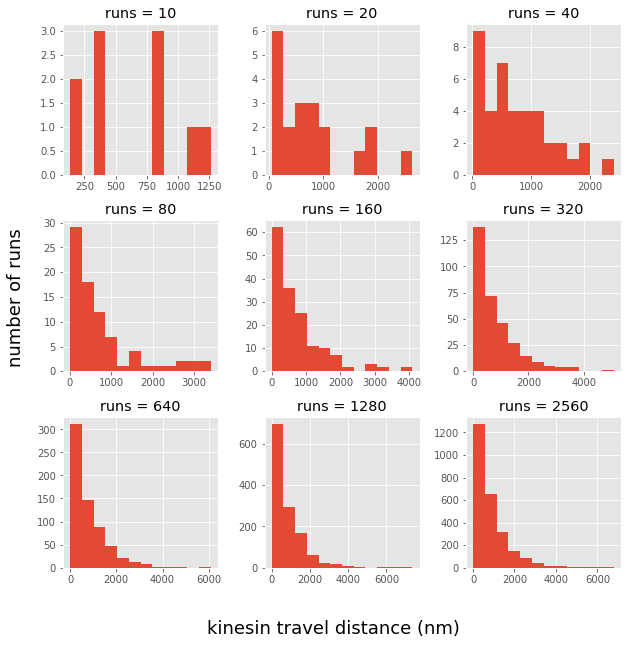

In [251]:
fig, axarr = plt.subplots(3,3, figsize=(10,10))
font = {'weight': 'normal',
        'size': 18}

runs = 10
for i in range(3):
    for j in range(3):
        cur_df = pd.DataFrame(data=simulate_microtubule(runs, 10000, 99, 102),
                      columns=["motor_steps","travel_distance","time_steps","velocity", "runs"]) 
        df = pd.concat([df, cur_df])
        cur_df.hist(column="travel_distance", ax=axarr[i,j], bins=12)
        axarr[i,j].set_title("runs = {}".format(runs))
        runs *= 2


fig.text(0.5, 0.04, 'kinesin travel distance (nm)', ha='center', va='center', fontdict=font)
fig.text(0.06, 0.5, 'number of runs', ha='center', va='center', rotation='vertical', fontdict=font)



In [253]:
df.describe()

,motor_steps,travel_distance,time_steps,velocity,runs
count,40660.000000,40660.000000,40660.000000,40660.000000,40660.000000
mean,100.868224,806.945794,10095.639621,798.296161,3748.858829
std,101.422947,811.383572,10107.545885,206.695202,3656.499826
min,0.000000,0.000000,1.000000,0.000000,10.000000
25%,28.000000,224.000000,2883.000000,731.629714,1280.000000
50%,70.000000,560.000000,7010.500000,796.204616,2560.000000
75%,140.000000,1120.000000,13950.500000,861.605283,2560.000000
max,1053.000000,8424.000000,111867.000000,8888.888889,10000.000000


### C:

Determine what sample size is required for reasonable estimate of the distribution’s
properties. First, confirm that your simulation is working correctly—generate a really large
number of runs (eg 10,000, and confirm that the mean travel is about 800 nm. If not, there is
a problem in your simulation). Next, for each choice of sample size from B, generate many
samples of that size, and determine a 95% CI (using standard t-test approach discussed in
class) and for each sample determine whether the calculated CI contains the actual mean of
the population (which you know to be 800 nm, by construction). Then, for that sample size,
determine the proportion of correct events, i.e. the number of tests that included 800, divided
by the total number of tests. Plot a graph of the proportion, as a function of the number of
elements in the sample. At some point (i.e. for some sample size N), the proportion should
get close to 0.95. When is that?
Finally, for each sample size, use the statistic we discussed in class (on proportions) : for
each sample size, does the 95% CI include 0.95?

In [302]:
def confidence_interval(df, num_runs, num_subsets, confidence=0.95):

#     runs_df = df[df["runs"] == num_runs]
#     subsets = []
#     for i in range(1,num_subsets):
#         subsets.append(runs_df.iloc[i*num_runs:(i+1)*num_runs])
    subsets = df.sample(num_runs)
    m, se = subsets.mean()["travel_distance"], scipy.stats.sem(subsets["travel_distance"])
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [308]:
confidence_interval(df, 40000, 6)

(806.4178, 796.4956773532039, 816.3399226467963)

Text(0,0.5,'travel distance (nm)')

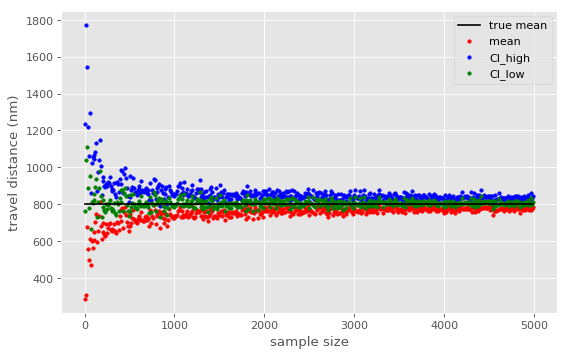

In [361]:
lower, means, upper = [],[],[]

for i in np.arange(10,5000,10):
    m,l,u = confidence_interval(df,i,6)
    lower.append(l)
    means.append(m)
    upper.append(u)

fig, ax = plt.subplots(1,1,figsize=(8,5),dpi=80)
ax.scatter(np.arange(10,5000,10), lower,s=10,color="red")
ax.scatter(np.arange(10,5000,10), upper,s=10,color="blue")
ax.scatter(np.arange(10,5000,10), means,s=10,color="green")
ax.plot(np.arange(10,5000,10), [800 for i in range(len(means))],color="black")
ax.legend(["true mean","mean","CI_high", "CI_low"])
ax.set_xlabel("sample size")
ax.set_ylabel("travel distance (nm)")